In [10]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import log_loss

In [11]:
# load raw financial data
# hourly resolution
gamestop_data = pd.read_csv('../foobar/data/raw/stock_candle_60_2020-03-01_2021-03-01.csv')
gamestop_data = gamestop_data.sort_values(by=['timestamp'], axis=0)
gamestop_data['datetime'] = pd.to_datetime(gamestop_data['timestamp'], unit='s')
gamestop_data = gamestop_data.set_index('datetime')

# resmaple the data hourly and pad the gaps with the previous record
gamestop_data = gamestop_data.resample('H', label='right').pad()
print(gamestop_data.shape)

train_data = gamestop_data[gamestop_data.index.year == 2020]
short_squeeze_data = gamestop_data[gamestop_data.index.year == 2021]
print(train_data.shape)
print(short_squeeze_data.shape)

train_data

(7692, 8)
(6395, 8)
(1297, 8)


,Unnamed: 0,close_price,high-price,low-price,open_price,status,timestamp,volume
datetime,,,,,,,,
2020-04-09 13:00:00,0,3.70,3.72,3.450,3.450,ok,1586437200,319130
2020-04-09 14:00:00,1,3.86,3.90,3.685,3.700,ok,1586440800,620809
2020-04-09 15:00:00,2,4.06,4.08,3.800,3.865,ok,1586444400,1023287
2020-04-09 16:00:00,3,4.12,4.19,3.890,4.060,ok,1586448000,602239
2020-04-09 17:00:00,4,4.03,4.25,3.870,4.130,ok,1586451600,1006734
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,4,18.99,19.47,18.910,19.470,ok,1609441200,792064
2020-12-31 20:00:00,5,18.81,19.03,18.800,18.980,ok,1609444800,1081315
2020-12-31 21:00:00,6,18.80,18.95,18.290,18.840,ok,1609448400,1270488


## Data Preprocessing

In [12]:
# create train and test dataset
# sorted based on timestamp 

# extract timestamps for visualization
train_datetime_list = list(train_data.index)
target_datetime_list = list(short_squeeze_data.index)

# reordering the columns: put the prediction column to the last column
cols = ['open_price', 'high-price', 'low-price', 'volume','close_price']
df_train = train_data[cols]
df_target = short_squeeze_data[cols]

# check the df column types to ensure they have correct types
print(df_train.dtypes)
cols

open_price     float64
high-price     float64
low-price      float64
volume           int64
close_price    float64
dtype: object


['open_price', 'high-price', 'low-price', 'volume', 'close_price']

<AxesSubplot:xlabel='datetime'>

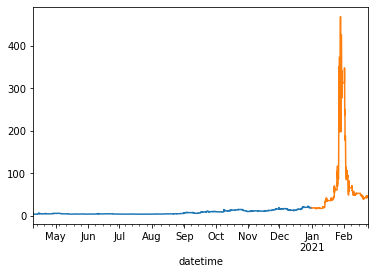

In [13]:
df_train['close_price'].plot()
df_target['close_price'].plot()

In [14]:
# finding missing values
df_train.isnull().sum()

open_price     0
high-price     0
low-price      0
volume         0
close_price    0
dtype: int64

In [15]:
df_target.isnull().sum()

open_price     0
high-price     0
low-price      0
volume         0
close_price    0
dtype: int64

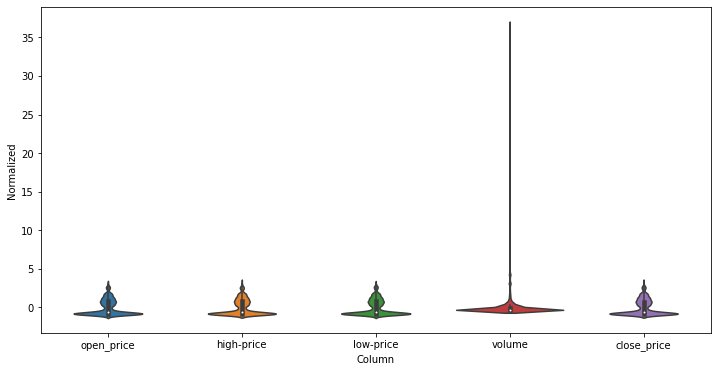

In [16]:
# Visualize the ditribution of the features in the train dataset
df_std = (df_train - df_train.mean()) / df_train.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)


In [17]:
def scale(df_train, df_target, feature_set):
    sc = StandardScaler()
    train_arr = sc.fit_transform(df_train[feature_set])
    target_arr = sc.fit_transform(df_target[feature_set])
    return train_arr, target_arr

def split(train_arr, train_ratio):
    # split the data to train, validate
    n = len(train_arr)
    train_set = train_arr[:int(n*train_ratio)]
    val_set = train_arr[int(n*train_ratio):]
    return train_set, val_set

### Data Windowing for time series forecasting

> Refer to [Data Windowing](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) for more details


In [31]:
# Generate time windows for time series forecasting with LSTM network
def generate_window(dataset, train_window, pred_horizon):
    dataset_seq = []
    size = len(dataset)
    x_arr = []
    y_arr = []
    for i in range(size - train_window - pred_horizon):
        x = dataset[i:(i+train_window), :-1]
        y = dataset[i+train_window+pred_horizon-1:i+train_window+pred_horizon, -1]
        x_arr.append(x)
        y_arr.append(y)

    x_tensor = torch.tensor(x_arr).float()
    y_tensor = torch.tensor(y_arr).float()
    num_features = x_tensor.shape[2]
    tensor_dataset = TensorDataset(x_tensor,y_tensor)
    batch_size = 100
    tensor_dataloader = DataLoader(tensor_dataset, batch_size, False)
    dataset_seq = (x_tensor, y_tensor)
    return tensor_dataloader, num_features

In [32]:
# various feature set for model selection
feature_set1 = ['open_price', 'high-price', 'low-price', 'volume', 'close_price']
feature_set2 = ['open_price', 'high-price', 'low-price', 'close_price']
feature_set3 = ['open_price', 'volume', 'close_price']
feature_set4 = ['volume', 'close_price']
feature_sets = [feature_set1, feature_set1, feature_set3, feature_set4]

# let's create sequential training dataset with various traning windows and prediction horizons
# given that the times series data has 1-hour resolution
# 24hours * (days)
train_window_list = 24 * np.array([5, 10, 30])
prediction_horizon_list = 24 * np.array([1, 2, 3, 5, 10])


train_set, target_set = scale(df_train, df_target, feature_sets[0])
train_set , val_set = split(train_set, 0.8)

train_window = train_window_list[0]
prediction_horizon = prediction_horizon_list[0]

train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
val_seq, _ = generate_window(val_set, train_window, prediction_horizon)
target_seq, _ = generate_window(target_set, train_window, prediction_horizon)

datetime_target = target_datetime_list[train_window+prediction_horizon:]


In [63]:
for dnx, batch in enumerate(train_seq):
    x, y = batch
    print(x.size(0))
    break

100


## Creating LSTM Network

In [64]:
class LSTM(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size=100, num_layers = 2, output_size=1):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seq_len = seq_length
        
        self.hidden = None

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )

        self.linear = nn.Linear(self.hidden_size * self.seq_len, self.output_size)

    def init_hidden(self, batch_size, device):
        self.hidden_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.cell_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.hidden = (self.hidden_state, self.cell_state)

    def forward(self, x, forecast_timesteps = 0):
        batch_size = x.size(0)
        print(batch_size)
#         if self.hidden is None:
#             self.init_hidden(batch_size)
#         print(batch_size)
#         h_0 = torch.zeros(self.num_layers, batch_size ,self.hidden_size)
#         c_0 = torch.zeros(self.num_layers, batch_size ,self.hidden_size)
        
        lstm_out, self.hidden = self.lstm(
                x,
                self.hidden
            )
        
        outputs = self.linear(lstm_out.reshape(batch_size,-1))

        return outputs


## Traning LSTM model

In [65]:
def train_model(model, device, train_seq, val_seq=None, num_epochs=200):
#     X_train, y_train = train_seq
#     inputs, labels = X_train.to(device), y_train.to(device)
#     if val_seq is not None:
#         X_val, y_val = val_seq
#         inputs_val, labels_val = X_val.to(device), y_val.to(device)

    learning_rate = 1e-3
    best_loss = np.Inf
    val_loss = None
    history = dict(train=[], val=[])

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        for batch_ndx, batch in enumerate(train_seq):
            x, y = batch
            batch_size = x.size(0)
            x = x.to(device)
            y = y.to(device)
#             print(x.size(0))
#             inputs, labels = X_train.to(device), y_train.to(device)
            model.init_hidden(batch_size, device)
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss = loss.item()
            history['train'].append(train_loss)

#             if val_seq is not None:
#                 with torch.no_grad():
#                     model.eval()

#                     model.init_hidden(inputs_val.shape[0], device)
#                     pred = model(inputs_val)
#                     loss = criterion(pred, labels_val)
#                     val_loss = loss.item()
#                     history['val'].append(val_loss)
#                     if val_loss < best_loss:
#                         best_loss = val_loss
    #                     best_model_wts = copy.deepcopy(model.state_dict())

            print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

#         if val_loss < 0.05:
# #             best_model_wts = copy.deepcopy(model.state_dict())
#             break
   
    return model.eval(), history

In [66]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model = LSTM(input_size=num_features, seq_length=train_window)
model.to(device)

model, history = train_model(model, device, train_seq)

plt.plot(history['train'], label="Training loss")
plt.plot(history['val'], label="Test loss")
plt.legend()

100
Epoch 0: train loss 0.487871915102005 val loss None
100
Epoch 0: train loss 0.07698725908994675 val loss None
100
Epoch 0: train loss 0.023337287828326225 val loss None
100
Epoch 0: train loss 0.33254751563072205 val loss None
100
Epoch 0: train loss 0.18081313371658325 val loss None
100
Epoch 0: train loss 0.0011182560119777918 val loss None
100
Epoch 0: train loss 0.05464041233062744 val loss None
100
Epoch 0: train loss 0.16100448369979858 val loss None
100
Epoch 0: train loss 0.11007589101791382 val loss None
100
Epoch 0: train loss 0.08874188363552094 val loss None
100
Epoch 0: train loss 0.03671497106552124 val loss None
100
Epoch 0: train loss 0.010680302046239376 val loss None
100
Epoch 0: train loss 0.0019474627915769815 val loss None
100
Epoch 0: train loss 0.06557377427816391 val loss None
100
Epoch 0: train loss 0.05609673261642456 val loss None
100
Epoch 0: train loss 0.06063990294933319 val loss None
100
Epoch 0: train loss 0.01103318203240633 val loss None
100
Epoch 

Epoch 2: train loss 0.01713350974023342 val loss None
100
Epoch 2: train loss 0.16883791983127594 val loss None
100
Epoch 2: train loss 0.06318677961826324 val loss None
100
Epoch 2: train loss 0.09031947702169418 val loss None
100
Epoch 2: train loss 0.05515911802649498 val loss None
100
Epoch 2: train loss 0.0851076990365982 val loss None
100
Epoch 2: train loss 0.9656358361244202 val loss None
100
Epoch 2: train loss 0.5214938521385193 val loss None
72
Epoch 2: train loss 0.09352242946624756 val loss None
100
Epoch 3: train loss 2.0782294273376465 val loss None
100
Epoch 3: train loss 1.4546148777008057 val loss None
100
Epoch 3: train loss 1.0012962818145752 val loss None
100
Epoch 3: train loss 0.24073214828968048 val loss None
100
Epoch 3: train loss 0.09147245436906815 val loss None
100
Epoch 3: train loss 0.045266736298799515 val loss None
100
Epoch 3: train loss 0.0038614151999354362 val loss None
100
Epoch 3: train loss 0.02440253272652626 val loss None
100
Epoch 3: train los

Epoch 5: train loss 0.7702118754386902 val loss None
100
Epoch 5: train loss 0.7299423217773438 val loss None
100
Epoch 5: train loss 1.099672555923462 val loss None
100
Epoch 5: train loss 1.2656232118606567 val loss None
100
Epoch 5: train loss 0.8257370591163635 val loss None
100
Epoch 5: train loss 0.021341990679502487 val loss None
100
Epoch 5: train loss 0.031852830201387405 val loss None
72
Epoch 5: train loss 0.026914140209555626 val loss None
100
Epoch 6: train loss 0.318154513835907 val loss None
100
Epoch 6: train loss 0.3054082691669464 val loss None
100
Epoch 6: train loss 0.2931837737560272 val loss None
100
Epoch 6: train loss 0.06725379824638367 val loss None
100
Epoch 6: train loss 0.12912623584270477 val loss None
100
Epoch 6: train loss 0.1234516054391861 val loss None
100
Epoch 6: train loss 0.0072599067352712154 val loss None
100
Epoch 6: train loss 0.021822642534971237 val loss None
100
Epoch 6: train loss 0.16082483530044556 val loss None
100
Epoch 6: train loss 

KeyboardInterrupt: 

## Predictions

In [ ]:
predictions, losses = [], []
criterion = nn.L1Loss(reduction='sum').to(device)

with torch.no_grad():
    model.eval()
    for i in range(X_test.shape[0]):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        model.init_hidden(x_i.shape[0])
        y_pred = model(x_i)
        predictions.append(y_pred.cpu().numpy().flatten())
        loss = criterion(y_pred, y_i)
        losses.append(loss.item())

truth = y_test.cpu().numpy().flatten()
predictions = np.array(predictions).flatten()

In [ ]:

plt.plot(datetime_target,predictions, label="Predictions")
plt.plot(datetime_target, truth, label="Truth")
plt.xticks(rotation=45)
plt.legend()

In [ ]:
plt.plot(datetime_target ,losses, label="Prediction Loss")
plt.xticks(rotation=45)
plt.legend()
np.mean(losses)

In [ ]:
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_index = 0
for train_window in train_window_list:
    for prediction_horizon in prediction_horizon_list:
        for feature_set in feature_sets:

            train_set, target_set = scale(df_train, df_target, feature_set)
            train_set , val_set = split(train_set, 0.8)

            train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
            val_seq, _ = generate_window(val_set, train_window, prediction_horizon)
            target_seq, _ = generate_window(target_set, train_window, prediction_horizon)

            datetime_target = test_datetime_list[train_window+prediction_horizon:]

            model = LSTM(input_size=num_features, seq_length=train_window)
            model = model.to(device)

            model, history = train_model(model, device, train_seq, val_seq)
            model_index += 1

            print('Saving...')
            state = {
                'model': model,
                'feature_set': feature_set,
                'history': history,
                'pred_horizon': prediction_horizon,
                'train_window': train_window
            }

            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, f'./checkpoint/train_{model_index}.pth')
